# Week 5 Challange - GAN

### In this notebook, we'll solve Monet's Style Transfer Challange with CycleGans, an specific GAN Architecture that allows us to tackle the unpaired image problem 

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import GroupNormalization
from tensorflow.keras.optimizers import Adam
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
        if tf.config.list_physical_devices('GPU'):
            strategy = tf.distribute.MirroredStrategy()
            print("Running on GPU.")
        else:
            strategy = tf.distribute.get_strategy()
            print("Running on CPU.")

print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Running on CPU.
Number of replicas: 1
2.15.0


### Let's start by loading the dataset

In [9]:
MONET_FILENAMES = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


### Helper Methods to decode sample images and load dataset

In [10]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3) # 3 channels for RGB
    image = (tf.cast(image, tf.float32) / 127.5) - 1 # rescale each channel to [-1,1]
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

#function to parse a TFRecord file's structure. This is passed into the dataset.map function for decoding
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

#function to load the entire dataset from each TFRecord. Maps using the above TFRecord file structure
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

## Visualizing samples from the photos and monet's dataset, for style comparison 

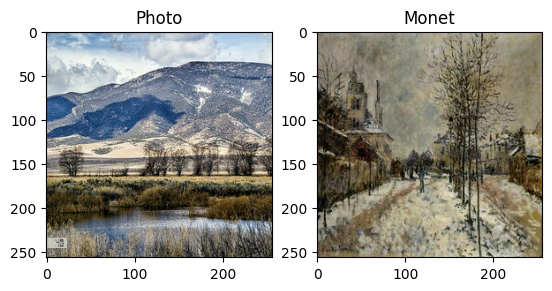

In [14]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

### Downsampling

In [18]:
#creates a downsampling block
def downsample(filters, size, i, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02) #kernel weight initialization

    result = keras.Sequential(name=f'Downsample_{i}')
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tf.keras.layers.GroupNormalization(groups=-1)) #Applies an instance normalization

    result.add(layers.LeakyReLU())

    return result

### Upsampling

In [19]:
def upsample(filters, size, i, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential(name=f'Upsample_{i}')
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tf.keras.layers.GroupNormalization(groups=-1))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

## Generator

### We'll Define a Generator with a Unet Architecture, with downsampling, encoding the main features with convolutional layers folowed by an umsampling, with Transpose Convolution and Dropout for regularization

In [20]:
OUTPUT_CHANNELS = 3
def Generator():
    inputs = layers.Input(shape=[256,256,3])
    
    #Set of downsample blocks, each downsample halves the image size due to stride=2
    # bs = batch size
    down_stack = [
        downsample(64, 4, 1, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4, 2), # (bs, 64, 64, 128)
        downsample(256, 4, 3), # (bs, 32, 32, 256)
        downsample(512, 4, 4), # (bs, 16, 16, 512)
        downsample(512, 4, 5), # (bs, 8, 8, 512)
        downsample(512, 4, 6), # (bs, 4, 4, 512)
        downsample(512, 4, 7), # (bs, 2, 2, 512)
        downsample(512, 4, 8), # (bs, 1, 1, 512)
    ]
    
    #Set of upsample blocks, each upsample doubles the image size due to stride=2.
    #The filter size should match its complimenting downsample for concatenation,
    #and should end with a (bs, 128, 128, filters) shape for the final tanh output layer
    up_stack = [
        upsample(512, 4, 7, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, 6, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, 5, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4, 4), # (bs, 16, 16, 1024)
        upsample(256, 4, 3), # (bs, 32, 32, 512)
        upsample(128, 4, 2), # (bs, 64, 64, 256)
        upsample(64, 4, 1), # (bs, 128, 128, 128)
    ]
    
    #Final upsampling, must be shaped (bs, 256, 256, 3)
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
        #print(x.shape[3])
        x = layers.Conv2D(x.shape[3], (3,3), strides=1, padding='same',
                             kernel_initializer=initializer, use_bias=False, activation=layers.LeakyReLU())(x)
        x = layers.Conv2D(x.shape[3], (3,3), strides=1, padding='same',
                             kernel_initializer=initializer, use_bias=False, activation=layers.LeakyReLU())(x)

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [21]:
test_generator = Generator()
test_generator.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Downsample_1        │ (None, 128, 128,  │      3,072 │ input_layer_1[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Downsample_2        │ (None, 64, 64,    │    131,328 │ Downsample_1[0][… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Downsample_3        │ (None, 32, 32,    │    524,800 │ Downsample_2[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Downsample_4        │ (None, 16, 16,    │  2,098,176 │ Downsample_3[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Downsample_5        │ (None, 8, 8, 512) │  4,195,328 │ Downsample_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Downsample_6        │ (None, 4, 4, 512) │  4,195,328 │ Downsample_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Downsample_7        │ (None, 2, 2, 512) │  4,195,328 │ Downsample_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Downsample_8        │ (None, 1, 1, 512) │  4,195,328 │ Downsample_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Upsample_7          │ (None, 2, 2, 512) │  4,195,328 │ Downsample_8[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ Upsample_7[0][0], │
│ (Concatenate)       │ 1024)             │            │ Downsample_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 2, 2,      │  9,437,184 │ concatenate[0][0] │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 2, 2,      │  9,437,184 │ conv2d_16[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Upsample_6          │ (None, 4, 4, 512) │  8,389,632 │ conv2d_17[0][0]   │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ Upsample_6[0][0], │
│ (Concatenate)       │ 1024)             │            │ Downsample_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 4, 4,      │  9,437,184 │ concatenate_1[0]… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 4, 4,      │  9,437,184 │ conv2d_18[0][0] 

 Total params: 136,105,603 (519.20 MB)

 Trainable params: 136,105,603 (519.20 MB)

 Non-trainable params: 0 (0.00 B)

## Discriminator

#### We'll define the discriminator, with 3 downsampling layers, encoding the main features from the generated image, and a final layer outputing a matrix with values between 0's and 1's, representing pixel "realness".

In [24]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, 1, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4, 2)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4, 3)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tf.keras.layers.GroupNormalization(groups=-1)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [25]:
test_discriminator = Discriminator()
test_discriminator.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Downsample_1 (Sequential)       │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Downsample_2 (Sequential)       │ (None, 64, 64, 128)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Downsample_3 (Sequential)       │ (None, 32, 32, 256)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 34, 34, 256)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 31, 31, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_26          │ (None, 31, 31, 512)    │         1,024 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_37 (LeakyReLU)      │ (None, 31, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_3                │ (None, 33, 33, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 30, 30, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,765,569 (10.55 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

## CycleGAN Architecture

#### We'll make use of a traditional CycleGan Architecture, that puts together the four 4 model:
- Photo Generator
- Monet Generator
- Photo Discriminator
- Monet Discriminator

#### Those four models compose the main architecture that allows CycleGan to learn, by having a flow that tranfers monet's style to the original image, and a recostruction flow, that aims to generate the original image from the styled one. 

In [26]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### Setting up both Generators and Discriminator for monet and photo classes

In [27]:
monet_generator = Generator() 
photo_generator = Generator() 

monet_discriminator = Discriminator() 
photo_discriminator = Discriminator()

monet_generator_optimizer = Adam(1e-4, beta_1=0.5)
photo_generator_optimizer = Adam(1e-4, beta_1=0.5)

monet_discriminator_optimizer = Adam(1e-4, beta_1=0.5)
photo_discriminator_optimizer = Adam(1e-4, beta_1=0.5)

### We'll be using Binary Cross entropy for the Discriminator loss, once the output output matrix is valued between 0's and 1's, determining how fake/real the image is. 

In [33]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

### Generator Loss

In [34]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

## CycleGAN loss

In [35]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

## Identity Loss

In [36]:
def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

## CycleGAN composition

In [38]:
device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")
    
print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU device not found
Found GPU at: 
GPU not available :(


In [37]:
#instantiate the cycleGAN
cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

#train the cycleGAN on the dataset
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25,
)

monet_generator.save("Monet_Generator.keras")

Epoch 1/25



KeyboardInterrupt



## Future Work

#### Due to time constrains, for future work we'll train the model over 25 Epochs, and evaluate it's performance on the original dataset, when transfering montet's style 

## Sources

- CycleGAN paper: https://arxiv.org/abs/1703.10593
- GAN Specialization: https://www.coursera.org/specializations/generative-adversarial-networks-gans
- Computerphile: https://www.youtube.com/watch?v=Sw9r8CL98N0&t=285s&ab_channel=Computerphile